<a href="https://colab.research.google.com/github/zia207/r-colab/blob/main/NoteBook/Advance_Regression/01_Generalized_Linear_Models/02-01-08-01-glm-gam-standard-r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1bLQ3nhDbZrCCqy_WCxxckOne2lgVvn3l)

# 7.1 Stansard Generalized Additive Models (GAM) {.unnumbered}

A **Standard GAM** (Generalized Additive Model) is the **basic and most commonly used form** of GAM. It extends the **Generalized Linear Model (GLM)** by allowing **non-linear, smooth relationships** between the predictors and the response variable, while maintaining **additivity** — meaning each predictor's effect is modeled separately and added together.

Instead of assuming a linear relationship like in GLMs (e.g., $\beta_1 X_1$, a Standard GAM uses **smooth functions** (like splines) to estimate the shape of the relationship directly from the data — without requiring you to specify whether it's quadratic, logarithmic, etc.


## Overview


For a response variable $Y$ with mean $\mu = \mathbb{E}[Y]$, and predictors $X_1, X_2, \dots, X_p$  a Standard GAM is written as:

$$
g(\mu) = \beta_0 + f_1(X_1) + f_2(X_2) + \cdots + f_p(X_p)
$$

Where:
- $g(\cdot)$ = **link function** (e.g., identity for normal, logit for binary, log for counts),
- $\beta_0$ = intercept,
- \( f_j(X_j) \) = **smooth, non-parametric function** of predictor \( X_j \) (usually estimated using splines).

> The model is "additive" because the effects of predictors are **summed**, not multiplied or interacted (unless explicitly added).



Suppose you're modeling **blood pressure** (continuous) as a function of:
- Age
- BMI
- Smoking status (categorical)

A Standard GAM might look like:

$$
\text{Blood Pressure} = \beta_0 + f_1(\text{Age}) + f_2(\text{BMI}) + \beta_1 \cdot \text{Smoking}
$$

Here:

- $f_1(\text{Age}$: smooth non-linear curve showing how BP changes with age,
- $f_2(\text{BMI})$: flexible curve for BMI effect,
- Smoking: linear (parametric) term.

Even if one term is linear, it's still considered a Standard GAM as long as smooth terms are present.



###  Key Properties

- `Support`: $y > 0$
- `Skewness`: Right-skewed; skewness decreases as $\lambda$ increases
- `Variance function`: $V(\mu) = \mu^3$
- `Use case`: When variance increases faster than quadratically with the mean (Gamma has $\mu^2$, Poisson has $\mu$)
- `Robustness`: Less sensitive to extreme outliers than Gamma in some contexts

### Advantages

| Benefit | Description |
|--------|-------------|
| **Flexibility** | Captures non-linear patterns automatically (e.g., U-shaped, threshold effects). |
| **Interpretability** | Each smooth function \( f_j(X_j) \) can be plotted and interpreted individually. |
| **No manual transformation needed** | You don’t have to guess if `log(X)` or `X²` fits better — the model learns the shape. |
| **Extends GLMs** | Works with binary, count, continuous, and other response types via link functions. |


### Limitations

| Limitation | Note |
|----------|------|
| **Assumes additivity** | Cannot capture interactions unless explicitly added (e.g., `te(x,z)`). |
| **May overfit** | Without proper smoothing penalties, it can fit noise. |
| **Smoothing parameter selection** | Requires careful tuning (but modern software like `mgcv` handles this well). |


### When to Use a  GAM?

Use a Standard GAM when:
- You suspect **non-linear relationships** (e.g., medical, ecological, or environmental data),
- You want a **balance between flexibility and interpretability**,
- You do **not expect strong interactions** among predictors (or will add them later),
- You're exploring data or building predictive models with smooth trends.

## Install rpy2

In [1]:
!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

Found existing installation: rpy2 3.5.17
Uninstalling rpy2-3.5.17:
  Successfully uninstalled rpy2-3.5.17
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp312-cp312-linux_x86_64.whl size=316567 sha256=8fa766b1a2342c55f87c42b3978814bbd8dd19738deb3a06a80282fdef9325e6
  Stored in directory: /root/.cache/pip/wheels/00/26/d5/d5e8c0b039915e785be870270e4a9263e5058168a03513d8cc
Successfully built rpy2


## Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Generalized Additive Model from Scratch

To develop a Generalized Additive Model (GAM) with 4 predictors from scratch in R, we’ll apply cubic spline basis functions to each predictor independently. This will allow each predictor to have a non-linear effect on the outcome variable. We’ll also include a regularization term to prevent overfitting. The model will be fit using least squares optimization.



### Generate Spline Basis for Each Predictor

For each predictor, we'll create a cubic spline basis matrix with `num_knots`. We'll use this basis for the GAM.


In [3]:
%%R
cubic_spline_basis <- function(x, knots) {
  X <- cbind(1, x, x^2, x^3)  # Polynomial terms up to cubic
  for (knot in knots) {
    X <- cbind(X, pmax(0, (x - knot)^3))  # Truncated cubic splines at each knot
  }
  return(X)
}

### Combine Spline Basis Functions into a Design Matrix

Next, we construct the full design matrix by generating spline basis functions for each predictor and concatenating them.

In [4]:
%%R
create_design_matrix <- function(data, predictors, num_knots) {
  X_spline <- NULL
  spline_list <- list()  # To store each predictor's spline basis

  for (predictor in predictors) {
    x <- data[[predictor]]
    knots <- seq(min(x), max(x), length.out = num_knots)  # Equally spaced knots
    X_spline_predictor <- cubic_spline_basis(x, knots)  # Generate spline basis
    spline_list[[predictor]] <- X_spline_predictor
    X_spline <- cbind(X_spline, X_spline_predictor)  # Append to design matrix
  }

  return(list(X_spline = X_spline, spline_list = spline_list))
}

### Fit the Model by Solving the Regularized System

Here, we add a small regularization term $\lambda$ to ensure the matrix $X^T X$ is invertible, then solve for the coefficients.

In [5]:
%%R
fit_gam_model <- function(X_spline, y, lambda = 0.0001) {
  XtX <- t(X_spline) %*% X_spline + lambda * diag(ncol(X_spline))  # Regularization
  Xty <- t(X_spline) %*% y
  coefficients <- solve(XtX, Xty)  # Solve for coefficients
  return(coefficients)
}

### Make Predictions

With the coefficients, we can predict the outcome for the training data.

In [6]:
%%R
predict_gam <- function(X_spline, coefficients) {
  y_pred <- X_spline %*% coefficients
  return(y_pred)
}

### Model Summary Statistics

After fitting, we’ll calculate residuals, deviance, and mean squared error to summarize model fit.

In [8]:
%%R
compute_summary_stats <- function(y, y_pred) {
  residuals <- y - y_pred
  deviance <- sum(residuals^2)  # Residual Sum of Squares
  mse <- mean(residuals^2)      # Mean Squared Error

  return(list(residuals = residuals, deviance = deviance, mse = mse))
}

### ANOVA-Like Table for Predictor Effects

We’ll estimate each predictor's effect by fitting sub-models with each individual predictor's spline matrix.
}

In [9]:
%%R
compute_anova_table <- function(data, response, predictors, spline_list, lambda = 0.0001) {
  anova_table <- data.frame(
    Predictor = predictors,
    Sum_of_Squares = sapply(predictors, function(predictor) {
      X_pred <- spline_list[[predictor]]
      XtX_single <- t(X_pred) %*% X_pred + lambda * diag(ncol(X_pred))
      Xty_single <- t(X_pred) %*% data[[response]]
      coefficients_single <- solve(XtX_single, Xty_single)
      residuals_single <- data[[response]] - X_pred %*% coefficients_single
      return(sum(residuals_single^2))
    })
  )
  return(anova_table)
}


### Cross-Validation for Model Performance

We’ll use **k-fold cross-validation** to estimate model performance on unseen data. Here’s the cross-validation setup:

In [10]:
%%R
cross_validate_gam <- function(data, response, predictors, num_knots = 3, lambda = 0.0001, k_folds = 5) {
  n <- nrow(data)
  fold_size <- n %/% k_folds
  indices <- sample(n)
  mse_folds <- numeric(k_folds)

  for (fold in 1:k_folds) {
    # Define training and validation sets
    validation_idx <- indices[((fold - 1) * fold_size + 1):(fold * fold_size)]
    train_data <- data[-validation_idx, ]
    validation_data <- data[validation_idx, ]

    # Create design matrix for training data
    train_design <- create_design_matrix(train_data, predictors, num_knots)
    X_train <- train_design$X_spline
    y_train <- train_data[[response]]

    # Fit the model on training data
    coefficients <- fit_gam_model(X_train, y_train, lambda)

    # Design matrix for validation data
    validation_design <- create_design_matrix(validation_data, predictors, num_knots)
    X_val <- validation_design$X_spline
    y_val <- validation_data[[response]]

    # Predict on validation set and calculate MSE
    y_val_pred <- predict_gam(X_val, coefficients)
    mse_folds[fold] <- mean((y_val - y_val_pred)^2)
  }

  cv_mse <- mean(mse_folds)  # Average MSE over folds
  return(cv_mse)
}

### Fit the GAM model with Synthetic Data

Let’s fit the GAM model on synthetic data and show summary results, ANOVA table, and cross-validation performance.

In [11]:
%%R
# Set up data and parameters
set.seed(0)
n_samples <- 100
data <- data.frame(
  x1 = seq(0, 10, length.out = n_samples),
  x2 = runif(n_samples, 0, 10),
  x3 = runif(n_samples, 0, 10),
  x4 = runif(n_samples, 0, 10)
)
data$y <- 3 * sin(data$x1) + 2 * log(data$x2 + 1) - 1.5 * sqrt(data$x3) + 0.5 * data$x4^2 +
  rnorm(n_samples, mean = 0, sd = 0.5)

predictors <- c("x1", "x2", "x3", "x4")
response <- "y"
num_knots <- 4
lambda <- 0.0001

# Create design matrix
design_matrix <- create_design_matrix(data, predictors, num_knots)
X_spline <- design_matrix$X_spline
spline_list <- design_matrix$spline_list

# Fit model and make predictions
coefficients <- fit_gam_model(X_spline, data[[response]], lambda)
y_pred <- predict_gam(X_spline, coefficients)

# Calculate summary statistics
summary_stats <- compute_summary_stats(data[[response]], y_pred)

# ANOVA table
anova_table <- compute_anova_table(data, response, predictors, spline_list, lambda)

# Cross-Validation
cv_mse <- cross_validate_gam(data, response, predictors, num_knots, lambda)

# Print results
cat("GAM Summary:\n")
cat("-----------------------------------------------------\n")
cat("Coefficients:\n")
print(coefficients)
cat("\nMean Squared Error:", round(summary_stats$mse, 4), "\n")
cat("Deviance:", round(summary_stats$deviance, 4), "\n")
cat("Residuals:\n")
print(head(summary_stats$residuals))
cat("\nANOVA for Parametric Effects:\n")
print(anova_table)
cat("\nCross-Validated MSE:", round(cv_mse, 4), "\n")

GAM Summary:
-----------------------------------------------------
Coefficients:
          [,1]
  -0.023161446
x  8.271536899
  -4.329322919
   0.275686636
   0.275695500
  -0.660576687
  -0.203910265
   0.000000000
  -0.023161433
x  0.613274246
   0.203200014
   0.001823434
  -0.046732545
   0.086780236
  -0.116798305
   0.000000000
  -0.023161434
x -1.996700892
   0.481029857
   0.116905330
  -0.174186312
   0.061741229
  -0.009306572
   0.000000000
  -0.023161429
x -0.634787868
   0.435048209
   0.250548166
  -0.258617892
  -0.003922149
  -0.010824794
   0.000000000

Mean Squared Error: 0.4349 
Deviance: 43.4897 
Residuals:
            [,1]
[1,]  1.19802648
[2,]  0.01107583
[3,]  0.02853082
[4,]  1.18566512
[5,]  0.29919007
[6,] -0.59918471

ANOVA for Parametric Effects:
   Predictor Sum_of_Squares
x1        x1     19152.0461
x2        x2     19581.0390
x3        x3     20748.8882
x4        x4       594.4656

Cross-Validated MSE: 478.694 


### Explanation of Output

1.  **Coefficients**: Estimated coefficients for each basis function in the design matrix.
2.  **MSE and Deviance**: Summary statistics of the model fit on the training data.
3.  **Residuals**: Differences between actual and predicted values.
4.  **ANOVA Table**: Shows the sum of squares contributed by each predictor.
5.  **Cross-Validated MSE**: Model’s performance on unseen data, averaged across folds. This gives an unbiased estimate of the model’s prediction error.

This approach builds the GAM model manually from scratch without relying on GAM-specific R packages, and it evaluates performance using cross-validation to check for overfitting or underfitting.


## Generalized Additive Model in R

In R, you can fit Generalized Additive Models (GAMs) using different packages, each offering unique functionalities. Here’s a quick guide to fitting GAMs using three popular packages:

1. **`mgcv` Package**

-   `mgcv` is the most widely used package for GAMs in R due to its flexibility, efficiency, and support for a wide range of models. It uses penalized regression splines by default.

-   **Key Features:** `mgcv` provides a variety of smooth functions (e.g., `s()`, `te()` for tensor product smoothing) and allows you to specify different distributions and link functions using `family=`.

2. **gam Package**

-   The `gam` package (distinct from `mgcv`) is based on Hastie and Tibshirani’s original GAM framework. It has a simpler interface but is less flexible than `mgcv` for complex models.

-   **Key Features:** The `gam` package is good for standard GAMs and allows `lo()` for locally-weighted regression smoothers. It’s simpler but lacks some of the advanced features found in `mgcv`.

 3. **`gamlss` Package**

-   `gamlss` (Generalized Additive Models for Location, Scale, and Shape) extends GAMs to model not only the mean (location) but also other parameters (e.g., scale, shape) of the distribution.

-   **Key Features:** `gamlss` is highly flexible for distributional modeling. It supports a wide range of distributions, including non-standard ones, and allows for different smoothers (e.g., `pb()` for P-splines).

### Install Required R Packages

Following R packages are required to run this notebook. If any of these packages are not installed, you can install them using the code below:

In [19]:
%%R
packages <- c('tidyverse',
     'plyr',
	  'DataExplorer',
		 'dlookr',
		 'rstatix',
		 'gtsummary',
		 'performance',
	   'report',
		 'sjPlot',
		 'margins',
		 'marginaleffects',
		 'ggeffects',
	   'ggpmisc',
		 'MASS',
	   'gam',
 		 'gamair',
 		 'mgcv',
 		 'gamlss',
 		 'gratia',
 		 #'itsadug',  # we will load this pacakge later
 		 'agridat'
	  	)


In [ ]:
%%R
# Install missing packages
new.packages <- packages[!(pkg %in% installed.packages(lib='drive/My Drive/R/')[,"Package"])]
if(length(new.packages)) install.packages(new.packages, lib='drive/My Drive/R/')

In [20]:
%%R
# set library path
.libPaths('drive/My Drive/R')
# Verify installation
cat("Installed packages:\n")
print(sapply(packages, requireNamespace, quietly = TRUE))

Installed packages:
      tidyverse            plyr    DataExplorer          dlookr         rstatix 
           TRUE            TRUE            TRUE            TRUE            TRUE 
      gtsummary     performance          report          sjPlot         margins 
           TRUE            TRUE            TRUE            TRUE            TRUE 
marginaleffects       ggeffects         ggpmisc            MASS             gam 
           TRUE            TRUE            TRUE            TRUE            TRUE 
         gamair            mgcv          gamlss          gratia         agridat 
           TRUE            TRUE            TRUE            TRUE            TRUE 


### Load packages

In [21]:
%%R
# set library path
.libPaths('drive/My Drive/R')
# Load packages with suppressed messages
invisible(lapply(packages, function(pkg) {
  suppressPackageStartupMessages(library(pkg, character.only = TRUE))
}))
# Check loaded packages
cat("Successfully loaded packages:\n")
print(search()[grepl("package:", search())])# Check loaded packages

Successfully loaded packages:
 [1] "package:agridat"         "package:gratia"         
 [3] "package:gamlss"          "package:parallel"       
 [5] "package:gamlss.dist"     "package:gamlss.data"    
 [7] "package:mgcv"            "package:nlme"           
 [9] "package:gamair"          "package:gam"            
[11] "package:foreach"         "package:splines"        
[13] "package:MASS"            "package:ggpmisc"        
[15] "package:ggpp"            "package:ggeffects"      
[17] "package:marginaleffects" "package:margins"        
[19] "package:sjPlot"          "package:report"         
[21] "package:performance"     "package:gtsummary"      
[23] "package:rstatix"         "package:dlookr"         
[25] "package:DataExplorer"    "package:plyr"           
[27] "package:lubridate"       "package:forcats"        
[29] "package:stringr"         "package:dplyr"          
[31] "package:purrr"           "package:readr"          
[33] "package:tidyr"           "package:tibble"         
[

### Data

In this exercise, we utilize a [dataset](https://raw.githubusercontent.com/m-clark/generalized-additive-models/master/data/pisasci2006.csv) that includes average science scores by country from the Programme for International Student Assessment ([PISA](https://www.oecd.org/en/about/programmes/pisa.html)) conducted in 2006. Alongside these scores, we also consider [data](https://hdr.undp.org/data-center) from the United Nations, which includes Gross National Income (GNI) per capita (adjusted for Purchasing Power Parity in 2005 dollars), the Educational Index, the Health Index, and the Human Development Index (HDI).

The education component is measured by the mean years of schooling for adults aged 25 years and older and the expected years of schooling for children of school entry Income. The health index is determined by life expectancy at birth, while the wealth component is based on GNI per capita. The HDI establishes minimum and maximum values for each dimension, with the resulting scores indicating each country's position relative to these endpoints, expressed as a value between 0 and 1.

The key variables are as follows (variable abbreviations in bold):

-   **Overall** Science Score (average score for 15 year olds)

-   **Interest** in science

-   Identifying scientific **Issues**

-   **Explaining** phenomena scientifically

-   **Support** for scientific inquiry

-   **Income** Index

-   **Health** Index

-   **Edu**cation Index

-   **H**uman **D**evelopment **I**ndex (composed of the Income index, Health Index, and Education Index)

We will use `read_csv()` function of {readr} package to import data as a **tidy** data.


In [22]:
%%R
mf<-readr::read_csv("https://raw.githubusercontent.com/m-clark/generalized-additive-models/master/data/pisasci2006.csv")
# Remove missing values
mf<-na.omit(mf)
str(mf)

Rows: 65 Columns: 11
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): Country
dbl (10): Overall, Issues, Explain, Evidence, Interest, Support, Income, Hea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
tibble [52 × 11] (S3: tbl_df/tbl/data.frame)
 $ Country : chr [1:52] "Argentina" "Australia" "Austria" "Belgium" ...
 $ Overall : num [1:52] 391 527 511 510 390 434 534 438 542 388 ...
 $ Issues  : num [1:52] 395 535 505 515 398 427 532 444 528 402 ...
 $ Explain : num [1:52] 386 520 516 503 390 444 531 432 549 379 ...
 $ Evidence: num [1:52] 385 531 505 516 378 417 542 440 542 383 ...
 $ Interest: num [1:52] 567 465 507 503 592 523 469 591 536 644 ...
 $ Support : num [1:52] 506 487 515 492 519 527 501 564 529 546 ...
 $ Income  : num [1:52] 0.678 0.826 0.835 0.831 0.637 0.663 0.84 0.673 0.853 0.616 ...
 $ Health  : num [

#### Data Visualization

We can use {ggplot2} to create a scatterplot matrix to visualize the relationships between the variables in the dataset.




In [23]:
%%R -w 1000 -h 1000 -u px
# create a data frame with the variables of interest
df<-mf |>
  dplyr::select(Country, Overall,Income, Health,  Edu, Interest)
# create a scatter plot  qith smooth line
p1<-ggplot(df, aes(x = Overall, y = Income)) +
  geom_point() +
  geom_smooth(method = "gam", formula = y ~ splines::bs(x, 4), se = TRUE)
p2<-ggplot(df, aes(x = Overall, y = Health)) +
  geom_point() +
  geom_smooth(method = "gam", formula = y ~ splines::bs(x, 4), se = TRUE)
p3<-ggplot(df, aes(x = Overall, y = Edu)) +
  geom_point() +
  geom_smooth(method = "gam", formula = y ~ splines::bs(x, 4), se = TRUE)
p4<-ggplot(df, aes(x = Overall, y = Interest)) +
  geom_point() +
  geom_smooth(method = "gam", formula = y ~ splines::bs(x, 4), se = TRUE)


The scatterplot matrix shows relationships between the four important variables in the `Overall` dataset. For example, the scatterplot of `Overall` vs. all for prectors reveals a non-linear relationship, suggesting a GAM might be appropriate.


#### Split Data

We will split the data into training and testing sets, The training set will contain 70% of the data, and the testing set will contain the remaining 30%.

In [25]:
%%R
# set the seed to make your partition reproducible
seeds = 11076
## 75% of the sample size
smp_size <- floor(0.75 * nrow(mf))
## set the seed to make your partition reproducible
set.seed(123)
train_ind <- sample(seq_len(nrow(mf)), size = smp_size)
train <- mf[train_ind, ]
test <- mf[-train_ind, ]

### Fit Univariate GAM Model

In this example, we’ll fit a univariate GAM model using the {mgcv}, {gam}, and {gamlss} packages to model the relationship between the `Overall` variable and a single predictor `Income` of `Overall` data set. We’ll use a cubic regression spline with 3 degrees of freedom. We will use `s()` is the shorthand for fitting smoothing splines in gam() function.



#### GAM with {mgcv} Package

{gam} function is used to fit a GAM model in the {mgcv} package. The `s()` function is used to specify a smooth term for the predictor `Income` using a cubic regression spline. `family()` object specifying the distribution and link to use in fitting etc.

In [26]:
%%R
library(mgcv)
# Fit a GAM model using the mgcv package
mgcv.uni <- mgcv::gam(Overall ~ s(Income), data = train,
              family= gaussian(link = "identity"))
summary(mgcv.uni)


Family: gaussian 
Link function: identity 

Formula:
Overall ~ s(Income)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  472.718      3.953   119.6   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
            edf Ref.df     F p-value    
s(Income) 7.585   8.49 20.47  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.817   Deviance explained = 85.3%
GCV = 781.25  Scale est. = 609.28    n = 39


summary(mgcv.uni) provides a summary of the fitted GAM model, including the estimated coefficients, degrees of freedom, and significance levels for each term. The `edf` column shows the effective degrees of freedom for the smooth term, which is a measure of the complexity of the fitted curve. The `p-value` column indicates the significance of the smooth term in the model. In this case, the smooth term for `Income` is highly significant (p \< 0.001), suggesting that `Income` has a non-linear effect on `Overall`. The `R-sq.(adj)` value represents the adjusted R-squared value of the model, which is a measure of how well the model fits the data. In this case, the adjusted R-squared value is 0.817, indicating that the model explains 81% of the variance in `Overall`.

The {gratia} package is designed to work with {mgcv} and offers enhanced visualization and diagnostic tools.


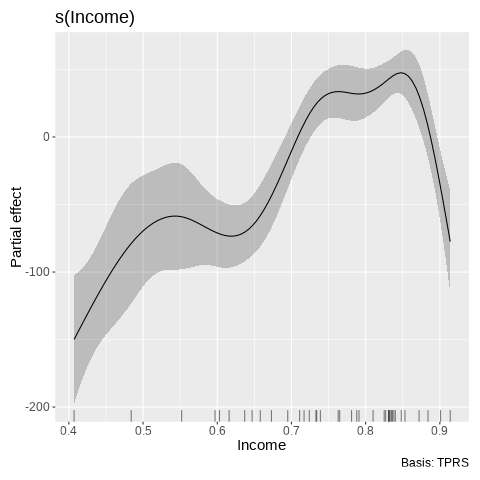

In [27]:
%%R
# Enhanced visualization
gratia::draw(mgcv.uni) # Generates nicely formatted plots

#### GAM with {gam} Package

The {gam} package provides a simpler interface for fitting GAMs. The `gam()` function is used to fit a GAM model with a cubic regression spline for the predictor `Income`. The `s()` function is used to specify a smooth term for the predictor `Income` using a cubic regression spline.

In [28]:
%%R -w 500 -h 450 -u px
##  you have to detach {mgcv} before using {gam} package
detach("package:mgcv", unload=F)
# Fit a GAM to model the relationship between mpg and hp
gam.uni <- gam::gam(Overall ~ s(Income), data = train,
                      family= gaussian(link = "identity"))
# Summary of the GAM
summary(gam.uni)


Call: gam::gam(formula = Overall ~ s(Income), family = gaussian(link = "identity"), 
    data = train)
Deviance Residuals:
    Min      1Q  Median      3Q     Max 
-94.230 -12.954   3.988  17.807  50.374 

(Dispersion Parameter for gaussian family taken to be 845.4251)

    Null Deviance: 126385.9 on 38 degrees of freedom
Residual Deviance: 28744.31 on 33.9998 degrees of freedom
AIC: 380.1803 

Number of Local Scoring Iterations: NA 

Anova for Parametric Effects
          Df Sum Sq Mean Sq F value   Pr(>F)    
s(Income)  1  60339   60339  71.371 7.26e-10 ***
Residuals 34  28744     845                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Anova for Nonparametric Effects
            Npar Df Npar F    Pr(F)    
(Intercept)                            
s(Income)         3 14.707 2.63e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Above output provides a summary of the fitted GAM model, including the estimated coefficients, degrees of freedom, and significance levels for each term. Anova for parametric effect shows the sum of squares contributed by each predictor. The `p-value` column indicates the significance of the smooth term in the model. In this case, the smooth term for `Income` is highly significant (p \< 0.001), suggesting that `Income` has a non-linear effect on `Overall`.

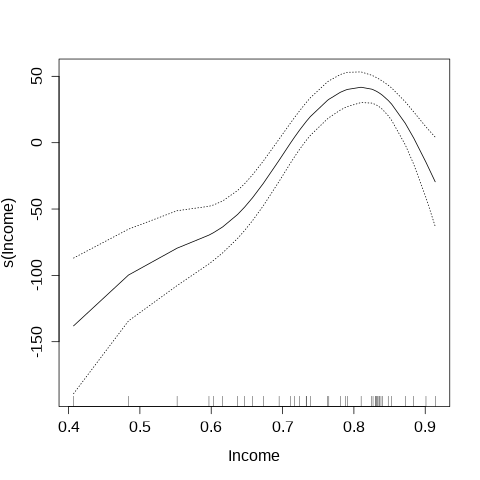

In [29]:
%%R
plot(gam.uni,se = TRUE)
#se stands for standard error Band

#### GAM with {gamlss} Package

`gamlss()` function fits a Generalized Additive Model for Location, Scale, and Shape (GAMLSS) using the {gamlss} package. This function allows for modeling the entire distribution of the response variable, not just the mean. The distribution for the response variable in the GAMLSS can be selected from a very general `family` of distributions including highly skew and/or kurtotic continuous and discrete distributions, and the parameters of the distribution can be modeled as functions of covariates.

We will use `pb()` is the shorthand for fitting smoothing function.

In [30]:
%%R
gamlss.uni <- gamlss(Overall ~ pb(Income), data = train, # pb() is a smooth function
                       family =NO) # NO() defines the normal distribution
summary(gamlss.uni)

GAMLSS-RS iteration 1: Global Deviance = 356.9995 
GAMLSS-RS iteration 2: Global Deviance = 356.9665 
GAMLSS-RS iteration 3: Global Deviance = 356.9672 
******************************************************************
Family:  c("NO", "Normal") 

Call:  gamlss(formula = Overall ~ pb(Income), family = NO,      data = train) 


Fitting method: RS() 

------------------------------------------------------------------
Mu link function:  identity
Mu Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   216.19      24.84   8.703 7.77e-10 ***
pb(Income)    342.32      32.77  10.447 1.09e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

------------------------------------------------------------------
Sigma link function:  log
Sigma Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   3.1576     0.1132   27.89   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

---------------------

******************************************************************
	      Summary of the Quantile Residuals
                           mean   =  -2.629949e-14 
                       variance   =  1.026316 
               coef. of skewness  =  -0.4128001 
               coef. of kurtosis  =  3.077463 
Filliben correlation coefficient  =  0.9841758 
******************************************************************


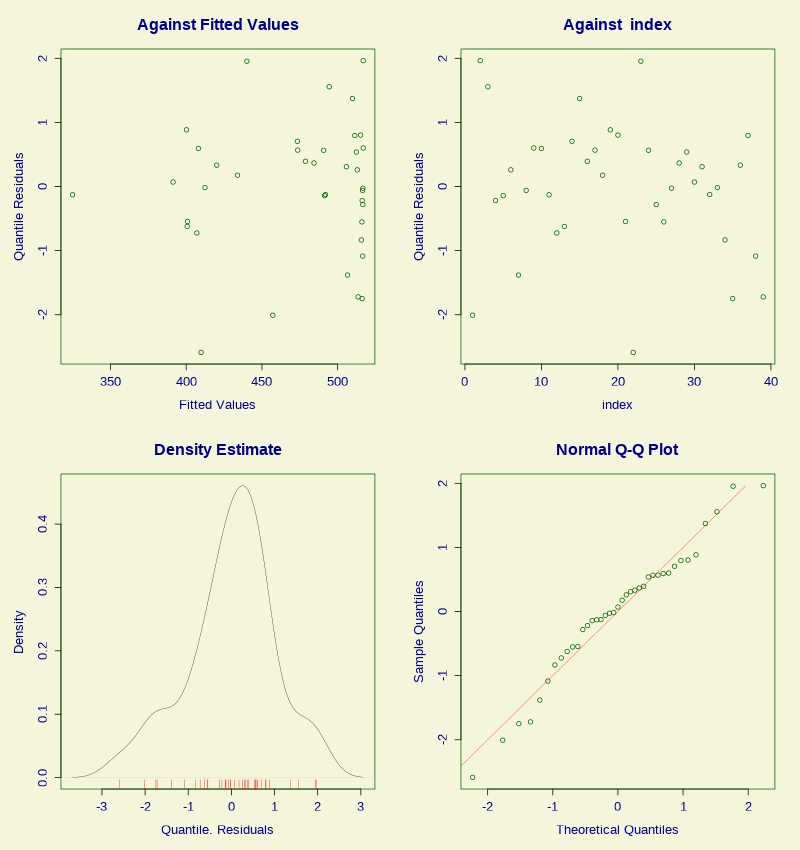

In [32]:
%%R -w 800 -h 850 -u px
plot(gamlss.uni,se = TRUE)
#se stands for standard error Band

### Fit Multivarite GAM Model

To fit a multivariate Generalized Additive Model (GAM) using the Overall dataset from the {ISLR} package in R, we can approach this using the {mgcv}, {gam}, and {gamlss} packages. We will model the relationship between the `Overall` variable and multiple predictors: `Income`, `Edu`, `Health` and `Interest`. We will use cubic regression splines for each predictor.


#### GAM with {mgcv} Package

{gam} function is used to fit a GAM model in the {mgcv} package. The `s()` function is used to specify a smooth term for the predictors `Income`, `Edu`, `Health` and `interest` using a cubic regression spline. `k` is the number of knots to use in the basis expansion. The default is 10. The `k` argument controls the smoothness of the fitted curve. We use k=15 for each predictor.


In [33]:
%%R -w 450 -h 400
library(mgcv)
# Fit a GAM model using the mgcv package
mgcv.multi <- mgcv::gam(Overall ~ s(Income, k=15) + s(Edu, k=15) + s(Health, k=15) + s(Interest, k=15), data = train,
              family= gaussian(link = "identity"))
summary(mgcv.multi)


Attaching package: ‘mgcv’



    lp



    gam, gam.control, gam.fit, s





Family: gaussian 
Link function: identity 

Formula:
Overall ~ s(Income, k = 15) + s(Edu, k = 15) + s(Health, k = 15) + 
    s(Interest, k = 15)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  472.718      2.582   183.1   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
              edf Ref.df     F p-value   
s(Income)   5.894  6.915 4.799 0.00356 **
s(Edu)      7.022  8.216 1.914 0.11761   
s(Health)   2.099  2.519 0.618 0.54811   
s(Interest) 5.131  6.081 2.276 0.08152 . 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.922   Deviance explained = 96.3%
GCV = 567.73  Scale est. = 259.92    n = 39


Above output provides a summary of the fitted GAM model, including the estimated coefficients, degrees of freedom, and significance levels for each term. The effective degrees of freedom (`edf`) column shows the effective degrees of freedom for the smooth term, which is a measure of the complexity of the fitted curve. The `p-value` column indicates the significance of the smooth term in the model. In this case, the smooth term for `Income` and `Interest` are highly significant (p \< 0.001), suggesting that both these predictors have a non-linear effect on `Overall`. The `R-sq.(adj)` value represents the adjusted R-squared value of the model, which is a measure of how well the model fits the data. In this case, the adjusted R-squared value is 0.92, indicating that the model explains 92% of the variance in `Overall`. The `GCV`, or generalized cross validation score can be taken as an estimate of the mean square prediction error based on a leave-one-out cross validation estimation process.

The {gratia} package is designed to work with {mgcv} and offers enhanced visualization and diagnostic tools.

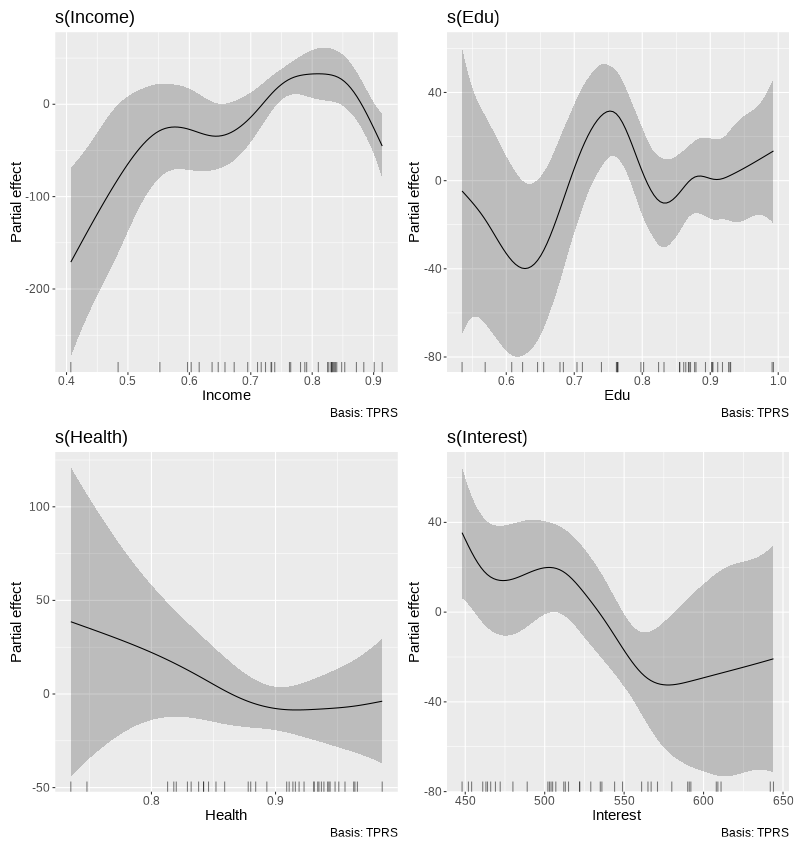

In [35]:
%%R -w 800 -h 850 -u px
# Enhanced visualization
gratia::draw(mgcv.multi) # Generates nicely formatted plots

Plot revels the fitted GAM model, including the smooth terms for `Income`, `Edu`, `Health`, and `Interest`. The solid lines represent the estimated relationships between each predictor and `Overall`, while the shaded areas represent the 95% confidence intervals around the estimates. The plot shows non-linear relationships between each predictor and `Overall`, with different patterns for each predictor. The smooth terms capture these non-linear relationships effectively.

#### GAM with {gam} Package

The {gam} package provides a simpler interface for fitting GAMs. The `gam()` function is used to fit a GAM model with a cubic regression spline for the predictor `Income`, `Edu`, `Health` and `Interest`. `df` is the degree of freedom for the spline.

In [36]:
%%R
##  you have to detach {mgcv} before using {gam} package
detach("package:mgcv", unload=TRUE)
# Fit a GAM to model the relationship between mpg and hp
gam.multi <- gam::gam(Overall ~ s(Income, df=15) + s(Edu, df=15) + s(Health, df=15) + s(Interest, df=15),  data = train,
                      family= gaussian(link = "identity"))
# Summary of the GAM
summary(gam.multi)


Call: gam::gam(formula = Overall ~ s(Income, df = 15) + s(Edu, df = 15) + 
    s(Health, df = 15) + s(Interest, df = 15), family = gaussian(link = "identity"), 
    data = train)

(Dispersion Parameter for gaussian family taken to be Inf)

    Null Deviance: 126385.9 on 38 degrees of freedom
Residual Deviance: 349.6113 on -21.9994 degrees of freedom
AIC: 320.2131 

Number of Local Scoring Iterations: NA 

Anova for Parametric Effects
                          Df Sum Sq Mean Sq   F value Pr(>F)
s(Income, df = 15)     1.000  53505   53505 -3366.803    NaN
s(Edu, df = 15)        1.000   2017    2017  -126.917    NaN
s(Health, df = 15)     1.000   1562    1562   -98.317    NaN
s(Interest, df = 15)   1.000   4731    4731  -297.707    NaN
Residuals            -21.999    350     -16                 

Anova for Nonparametric Effects
                     Npar Df Npar F Pr(F)
(Intercept)                              
s(Income, df = 15)        14      0      
s(Edu, df = 15)           14      0 

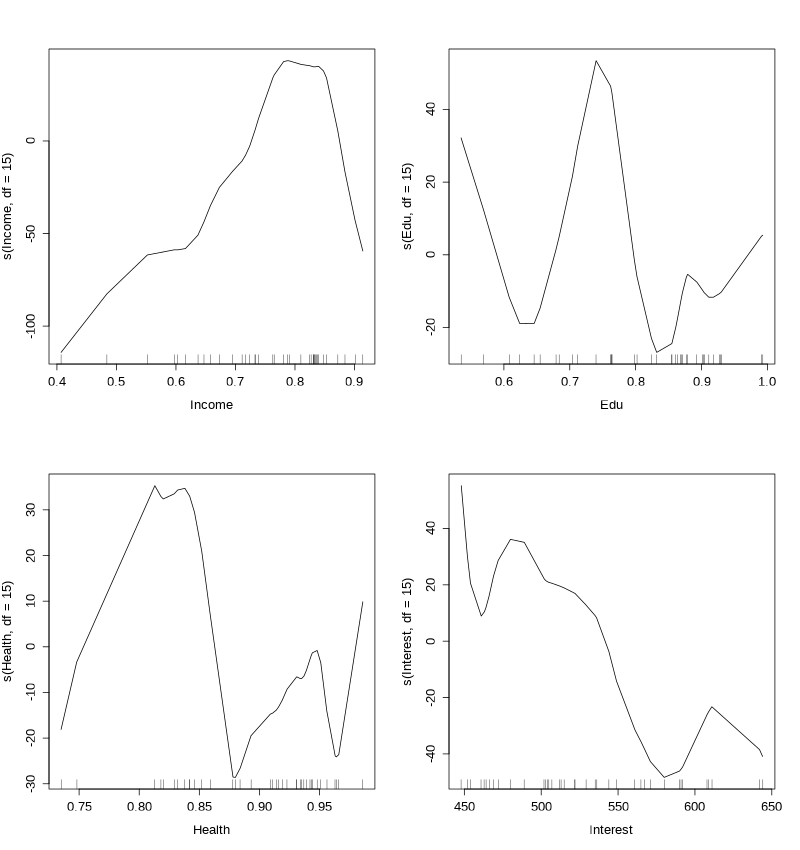

In [38]:
%%R -w 800 -h 850 -u px
#Plotting the Model
par(mfrow=c(2,2)) #to partition the Plotting Window
plot(gam.multi)
#se stands for standard error Band

#### GAM with {gamlss} Package

`gamlss()` function fits a Generalized Additive Model for Location, Scale, and Shape (GAMLSS) using the {gamlss} package. This function allows for modeling the entire distribution of the response variable, not just the mean. The distribution for the response variable in the GAMLSS can be selected from a very general `family` of distributions including highly skew and/or kurtotic continuous and discrete distributions, and the parameters of the distribution can be modeled as functions of covariates.

We will use `pb()` is the shorthand for fitting smoothing function.

In [39]:
%%R
gamlss.multi <- gamlss(Overall ~  pb(Income) + pb(Edu) + pb(Health) + pb(Interest), data = train, # pb() is a smooth function
                       family =NO) # NO() defines the normal distribution
summary(gamlss.multi)

GAMLSS-RS iteration 1: Global Deviance = 350.7869 
GAMLSS-RS iteration 2: Global Deviance = 350.7779 
GAMLSS-RS iteration 3: Global Deviance = 350.777 
******************************************************************
Family:  c("NO", "Normal") 

Call:  gamlss(formula = Overall ~ pb(Income) + pb(Edu) + pb(Health) +  
    pb(Interest), family = NO, data = train) 

Fitting method: RS() 

------------------------------------------------------------------
Mu link function:  identity
Mu Coefficients:
             Estimate Std. Error t value Pr(>|t|)   
(Intercept)  446.4572   140.8361   3.170  0.00359 **
pb(Income)   165.0185    68.3501   2.414  0.02234 * 
pb(Edu)      102.7553    61.0555   1.683  0.10317   
pb(Health)    17.9481   112.8893   0.159  0.87478   
pb(Interest)  -0.3709     0.1446  -2.564  0.01581 * 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

------------------------------------------------------------------
Sigma link function:  log
Sigma Coefficients:

From above output Global Deviance is 350.7, AIC is 371, BIC is 387.91 and Sigma Coefficients of estimates 3.70 (p<0.001). The `p-value` column indicates the significance of the smooth term in the model. In this case, the smooth term for `Income` and `Interest` are significant (p \< 0.05), suggesting that both these predictors have a non-linear effect on `Overall`.


******************************************************************
	      Summary of the Quantile Residuals
                           mean   =  -2.120698e-12 
                       variance   =  1.026316 
               coef. of skewness  =  0.2784542 
               coef. of kurtosis  =  3.311798 
Filliben correlation coefficient  =  0.986157 
******************************************************************


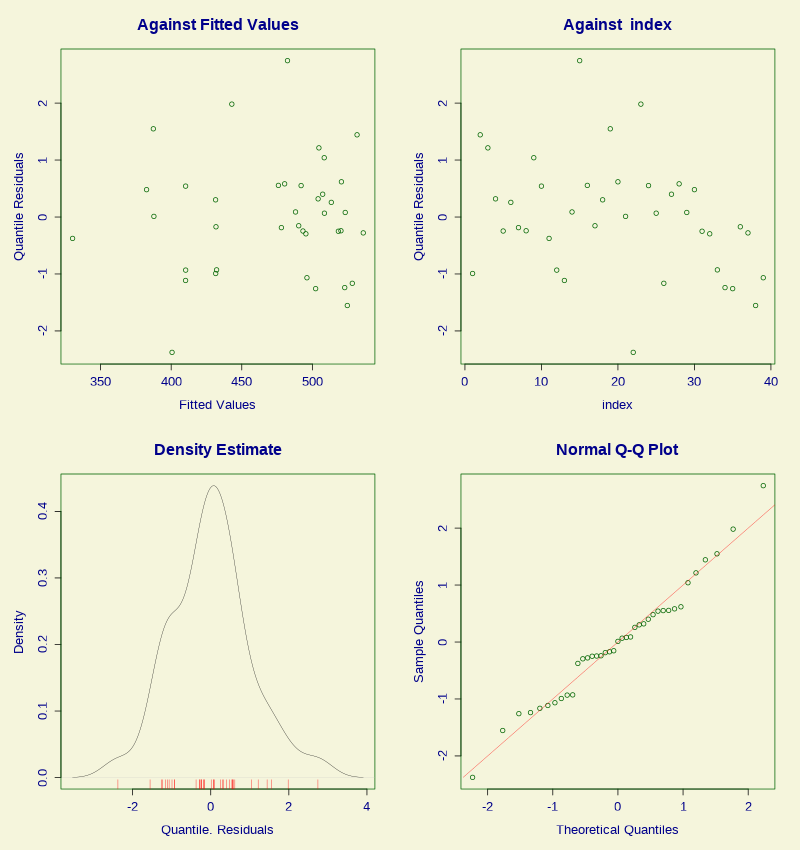

In [41]:
%%R -w 800 -h 850 -u px
plot(gamlss.multi,se = TRUE)

### GAM Models with Different Smoothing Functions

In the context of the `gam()` function from the **`mgcv`** package in R, **smoothing functions** (or **smooth terms**) are tools used to model non-linear relationships between predictors and the response variable. They allow the data to determine the shape of the relationship, rather than assuming a fixed functional form like linear or polynomial.

Common Smoothing Functions in `gam()`:

1. **`s()`**:
   - The most commonly used smoothing function in `gam()`.
   - Fits univariate or multivariate smooths using basis functions (e.g., splines).
   - Allows for flexible, data-driven modeling of non-linear effects.

   Example:
   ```R
   gam_model <- gam(y ~ s(x), data = dataset)
   ```

   Options within `s()`:
   - **`bs`**: Specifies the type of basis (default: "tp" for thin plate regression splines).
   - **`k`**: Controls the number of basis functions (higher values allow more flexibility).
   - **`fx`**: If `TRUE`, fits a fixed degree of smoothness.
   - **`by`**: Allows interaction with a categorical variable.

2. **`te()`**: Tensor product smooths
   - Models interactions between two or more predictors.
   - Useful when predictors are measured on different scales or units.

   Example:
   ```R
   gam_model <- gam(y ~ te(x1, x2), data = dataset)
   ```

3. **`ti()`**: Tensor interaction smooth
   - Similar to `te()` but fits an interaction without the main effects.

   Example:
   ```R
   gam_model <- gam(y ~ ti(x1, x2), data = dataset)
   ```

4. **`bs="cr"` (Cubic Regression Splines):**
   - A specific basis used within `s()`.
   - A good alternative to the default thin-plate regression splines.

   Example:
   ```R
   gam_model <- gam(y ~ s(x, bs = "cr"), data = dataset)
   ```

5. **`bs="cc"` (Cyclic Cubic Splines):**
   - Used for variables with cyclic behavior, like time of day or seasons.
   - Ensures the smooth term ends at the same value where it starts.

   Example:
   ```R
   gam_model <- gam(y ~ s(x, bs = "cc"), data = dataset)
   ```

6. **`bs="cs"` (Shrinkage Cubic Splines):**
   - Allows the model to shrink smooth terms to zero if the data supports it.

   Example:
   ```R
   gam_model <- gam(y ~ s(x, bs = "cs"), data = dataset)
   ```
   
7.  **`bs="tp"` (Thin plate regression spline (default):**
   - Allows the model to shrink smooth terms to zero if the data supports it.

   Example:
   ```R
   gam_model <- gam(y ~ s(x, bs = "tp"), data = dataset)
   ```

8. **`s()` with multiple predictors:**
   - Models multivariate smooths using multiple variables within one `s()` term.
   - Useful for non-linear interactions.

   Example:
   ```R
   gam_model <- gam(y ~ s(x1, x2), data = dataset)
   ```

Key Features of Smoothing in `gam()`:

1. **Automatic Smoothness Selection**:
   - `gam()` automatically determines the level of smoothness using techniques like **generalized cross-validation (GCV)** or **restricted maximum likelihood (REML)**.

2. **Penalty for Overfitting**:
   - Smoothness selection penalizes overly flexible models to prevent overfitting.

3. **Basis Dimension (`k`)**:
   - Determines the maximum complexity of the smooth.
   - Example: `s(x, k = 10)` uses 10 basis functions.

4. **Visualization**:
   - Smooth terms are easy to interpret visually using `plot()`.

   Example:
   ```R
   plot(gam_model, pages = 1)
   ```


In [42]:
%%R
library(mgcv)
# Thin plate regression spline
gam.tp <- gam(Overall ~ s(Income, bs="tp", k=15) +
                        s(Edu, bs="tp", k=15) +
                        s(Health, bs="tp", k=15) +
                        s(Interest, bs="tp", k=15),
                        method="REML",
                        data = train)

# Cubic regression spline
gam.cr <- gam(Overall ~ s(Income, bs="cr", k=15) +
                        s(Edu, bs="cr", k=15) +
                        s(Health, bs="cr", k=15) +
                        s(Interest, bs="cr", k=15),
                        method="REML",
                        data = train)

#  cubic-spline.
gam.cc <- gam(Overall ~ s(Income, bs="cc", k=15) +
                        s(Edu, bs="cc", k=15) +
                        s(Health, bs="cc", k=15) +
                        s(Interest, bs="cc", k=15),
                        method="REML",
                        data = train)


Attaching package: ‘mgcv’



    lp



    gam, gam.control, gam.fit, s




In [44]:
%%R
# Compare models using AIC
AIC(gam.tp, gam.cr, gam.cc)

             df      AIC
gam.tp 14.56445 368.0780
gam.cr 14.24128 368.0626
gam.cc 13.68113 378.5195


The effective degrees of freedom (EDF) gives a sense of the smoothness of each term. Higher EDF values indicate a more flexible curve, while lower values indicate more smoothing.

In [45]:
%%R
summary(gam.tp)$edf
summary(gam.cr)$edf
summary(gam.cc)$edf

[1] 4.3625195573 2.2771086914 0.0001987258 2.3567049721


#### Automatic Smoothing Parameter Search with {itsadug} Package

-   Use the {itsadug} package to compare different models with varied smooth terms automatically.

-   This package has the `compareML()` function to automatically compare a set of candidate models and select the one with the lowest AIC or other model selection criteria.


In [46]:
%%R
library(itsadug)
# Compare models
compareML(gam.cr, gam.tp)


Attaching package: ‘plotfunctions’



    alpha



Attaching package: ‘itsadug’



    dispersion



    get_predictions




gam.cr: Overall ~ s(Income, bs = "cr", k = 15) + s(Edu, bs = "cr", k = 15) + 
    s(Health, bs = "cr", k = 15) + s(Interest, bs = "cr", k = 15)

gam.tp: Overall ~ s(Income, bs = "tp", k = 15) + s(Edu, bs = "tp", k = 15) + 
    s(Health, bs = "tp", k = 15) + s(Interest, bs = "tp", k = 15)

Model gam.cr preferred: lower REML score (5.597), and equal df (0.000).
-----
   Model    Score Edf Difference    Df
1 gam.tp 168.7726   9                 
2 gam.cr 163.1753   9      5.597 0.000

AIC difference: -0.02, model gam.cr has lower AIC.



In [47]:
%%R
compareML(gam.cr, gam.cc)

gam.cr: Overall ~ s(Income, bs = "cr", k = 15) + s(Edu, bs = "cr", k = 15) + 
    s(Health, bs = "cr", k = 15) + s(Interest, bs = "cr", k = 15)

gam.cc: Overall ~ s(Income, bs = "cc", k = 15) + s(Edu, bs = "cc", k = 15) + 
    s(Health, bs = "cc", k = 15) + s(Interest, bs = "cc", k = 15)

Chi-square test of REML scores
-----
   Model    Score Edf Difference    Df   p.value Sig.
1 gam.cc 189.1265   5                                
2 gam.cr 163.1753   9     25.951 4.000 1.446e-10  ***

AIC difference: -10.46, model gam.cr has lower AIC.



#### Grid Search with {mgcv} and {purrr} Packages

Use `purrr::map` to loop over different smoothing functions and assess the best fit based on `AIC` or `GCV.` This method allows you to test several different smoothing options and select the best model.

-   In `gam()`, set the method to `"REML"` or `"GCV.Cp"` to let the model choose smoothing parameters that minimize either REML (restricted maximum likelihood) or GCV (generalized cross-validation) criteria.

-   **REML** is typically preferred because it often leads to smoother fits than GCV and is more stable in terms of penalizing overfitting.

In [48]:
%%R

#  List of smoothing basis types to test
smooth_types <- c("tp", "cr", "cc")

# Fit models with each type of smooth and calculate AIC
models <- purrr::map(smooth_types, ~ gam(Overall ~
            s(Income, bs = .x) +
            s(Edu, bs = .x) +
            s(Health, bs =.x) +
            s(Interest, bs =.x),
            data = train,
            method = "REML"))


aic_values <- map_dbl(models, AIC)

# Find the best model by minimum AIC
best_model <- models[[which.min(aic_values)]]
summary(best_model)


Family: gaussian 
Link function: identity 

Formula:
Overall ~ s(Income, bs = .x) + s(Edu, bs = .x) + s(Health, bs = .x) + 
    s(Interest, bs = .x)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  472.718      2.965   159.4   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
              edf Ref.df     F p-value   
s(Income)   5.237  6.117 5.454 0.00133 **
s(Edu)      5.068  5.919 1.834 0.13561   
s(Health)   1.603  1.948 0.182 0.80486   
s(Interest) 3.249  3.996 1.680 0.19019   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.897   Deviance explained = 93.8%
-REML = 164.75  Scale est. = 342.87    n = 39


The {gratia} package is designed to work with {mgcv} and offers enhanced visualization and diagnostic tools.

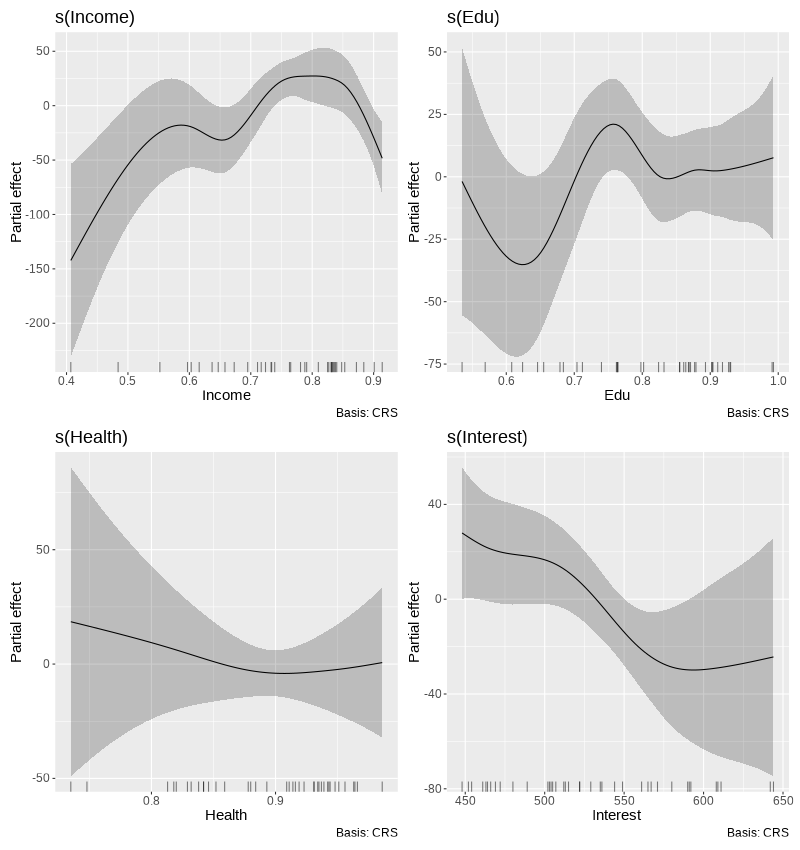

In [50]:
%%R -w 800 -h 850 -u px
# Enhanced visualization
gratia::draw(best_model) # Generates nicely formatted plots

#### Model Performance

In [51]:
%%R
performance::performance(best_model)

# Indices of model performance

AIC     |    AICc |     BIC |    R2 |   RMSE |  Sigma
-----------------------------------------------------
357.432 | 403.950 | 390.668 | 0.897 | 14.172 | 18.517


#### Prediction at Test Data

The `predict()` function will be used to predict the Overall Score at the test data. This will help to validate the accuracy of the GAM model.

In [52]:
%%R
# Predict the Overall Score at the test data
test$Pred.Overall<-as.data.frame(predict(best_model, newdata = test, type = "response", se=TRUE))

# Compute the MSE
mse <- mean((test$Overall- test$Pred.Overall$fit)^2)
print(paste("MSE:", round(mse, 4)))

[1] "MSE: 679.0869"


#### 1:1 Plot

We can plot observed and predicted values with fitted regression line with {ggplot2} and {ggpmisc} packages.

`geom_smooth()` using formula = 'y ~ x'


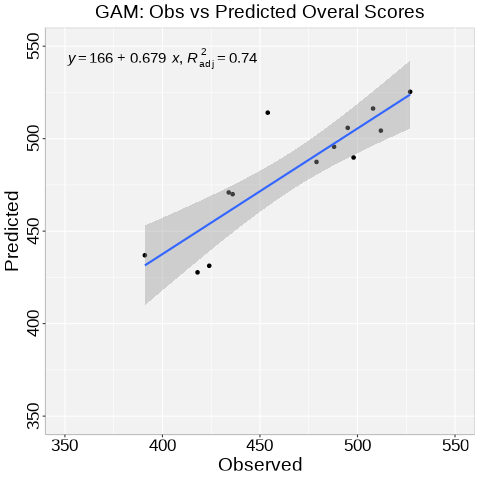

In [53]:
%%R
# load the ggpmisc package
library(ggpmisc)
formula<-y~x
# Plot the observed vs predicted Overall Scores
ggplot(test, aes(Overall,Pred.Overall$fit)) +
  geom_point() +
  geom_smooth(method = "lm")+
  stat_poly_eq(use_label(c("eq", "adj.R2")), formula = formula) +
  ggtitle("GAM: Obs vs Predicted Overal Scores ") +
  xlab("Observed") + ylab("Predicted") +
  scale_x_continuous(limits=c(350,550), breaks=seq(350, 550, 50))+
  scale_y_continuous(limits=c(350,550), breaks=seq(350, 550, 50)) +
  # Flip the bars
  theme(
    panel.background = element_rect(fill = "grey95",colour = "gray75",size = 0.5, linetype = "solid"),
    axis.line = element_line(colour = "grey"),
    plot.title = element_text(size = 14, hjust = 0.5),
    axis.title.x = element_text(size = 14),
    axis.title.y = element_text(size = 14),
    axis.text.x=element_text(size=13, colour="black"),
    axis.text.y=element_text(size=13,angle = 90,vjust = 0.5, hjust=0.5, colour='black'))

The plot shows the observed Overall Scores on the x-axis and the predicted Overall Scores on the y-axis. The points represent the observed values, while the line represents the fitted regression line. The equation of the regression line and the adjusted R-squared value are displayed on the plot. The plot shows a strong positive relationship between the observed and predicted Overall Scores, indicating that the GAM model is able to accurately predict the Overall Scores.


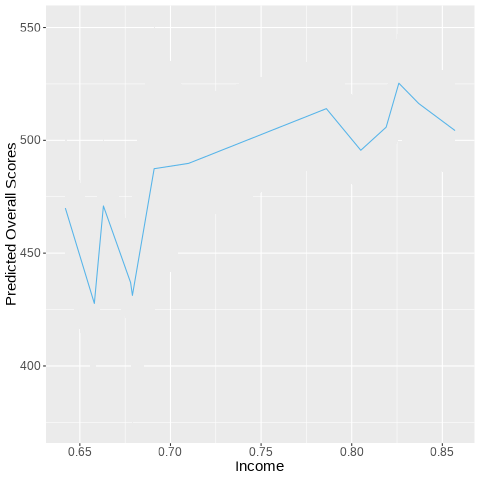

In [54]:
%%R
test<-test |>
  dplyr::mutate(lower = Pred.Overall$fit - 1.96 * Pred.Overall$se.fit,
         upper = Pred.Overall$fit + 1.96 * Pred.Overall$se.fit)

ggplot(aes(x = Income, y = Pred.Overall$fit), data = test) +
  geom_ribbon(aes(ymin = lower, ymax = upper), fill = 'gray92') +
  geom_line(color = '#56B4E9')+
  xlab("Income") + ylab("Predicted Overall Scores")

The plot shows the predicted Overall Scores as a function of Income, with a 95% confidence interval around the estimate. The shaded area represents the 95% confidence interval, while the line represents the estimated relationship between Income and Overall Scores. The plot shows a non-linear relationship between Income and Overall Scores, with the Overall Scores increasing with Income up to a certain point and then leveling off.

### GAM with Binnary Data - Logistic  Regression

In this example, we will fit a Poisson regression model to the `johnson.blight` dataset of {agridat} packages. A data frame with 25 observations on Potato blight due to weather in Prosser, Washington.

In [55]:
%%R
binary.data<-agridat::johnson.blight
glimpse(binary.data)

Rows: 25
Columns: 6
$ year     <int> 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1…
$ area     <int> 0, 0, 0, 0, 50, 810, 120, 40, 0, 0, 0, 0, 10100, 14150, 150, …
$ blight   <int> 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1…
$ rain.am  <int> 8, 9, 9, 6, 16, 10, 12, 10, 11, 8, 13, 8, 15, 9, 17, 5, 8, 5,…
$ rain.ja  <int> 1, 4, 6, 1, 6, 7, 12, 4, 10, 9, 1, 3, 6, 12, 1, 4, 3, 5, 3, 8…
$ precip.m <dbl> 5.84, 6.86, 47.29, 8.89, 7.37, 5.08, 3.30, 11.44, 14.99, 4.06…


In [56]:
%%R
# Define indicator for blight in previous year
binary.data$blight.prev[2:25] <-binary.data$blight[1:24]
binary.data$blight.prev[1] <- 0 # Need this to match the results of Johnson
binary.data$blight.prev <- factor(binary.data$blight.prev)
binary.data$blight <- factor(binary.data$blight)
glimpse(binary.data)

Rows: 25
Columns: 7
$ year        <int> 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979…
$ area        <int> 0, 0, 0, 0, 50, 810, 120, 40, 0, 0, 0, 0, 10100, 14150, 15…
$ blight      <fct> 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0…
$ rain.am     <int> 8, 9, 9, 6, 16, 10, 12, 10, 11, 8, 13, 8, 15, 9, 17, 5, 8,…
$ rain.ja     <int> 1, 4, 6, 1, 6, 7, 12, 4, 10, 9, 1, 3, 6, 12, 1, 4, 3, 5, 3…
$ precip.m    <dbl> 5.84, 6.86, 47.29, 8.89, 7.37, 5.08, 3.30, 11.44, 14.99, 4…
$ blight.prev <fct> 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0…


In [57]:
%%R
 logit.glm = glm(blight ~ blight.prev+rain.am + rain.ja + precip.m, data=binary.data, family=binomial)
 logit.gam = gam(blight ~ blight.prev+s(rain.am, rain.ja,k=5) + s(precip.m), data=binary.data, family=binomial)

In [58]:
%%R
anova(logit.glm, logit.gam, test="Chi")

Analysis of Deviance Table

Model 1: blight ~ blight.prev + rain.am + rain.ja + precip.m
Model 2: blight ~ blight.prev + s(rain.am, rain.ja, k = 5) + s(precip.m)
  Resid. Df Resid. Dev         Df   Deviance  Pr(>Chi)    
1        20     13.126                                    
2        20     13.126 1.8751e-05 2.1894e-05 0.0001017 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Despite the identical AIC values, the fact that the anova test is significant suggests we should use the more complex model, i.e. the GAM.

### GAM with Count Data - Poisson Regression

In this example, we will fit a Poisson regression model to the `mead.cauliflower` dataset of {agridat} packages. The datasethis dataset presents leaves for cauliflower plants at different times.

In [59]:
%%R
count.data<-agridat::mead.cauliflower
glimpse(count.data)

Rows: 14
Columns: 3
$ year    <int> 1956, 1956, 1956, 1956, 1956, 1956, 1956, 1957, 1957, 1957, 19…
$ degdays <dbl> 4.5, 7.5, 9.5, 10.5, 13.0, 16.0, 18.0, 4.5, 8.0, 9.5, 11.5, 13…
$ leaves  <int> 38, 62, 72, 87, 102, 135, 150, 60, 85, 91, 120, 126, 133, 152


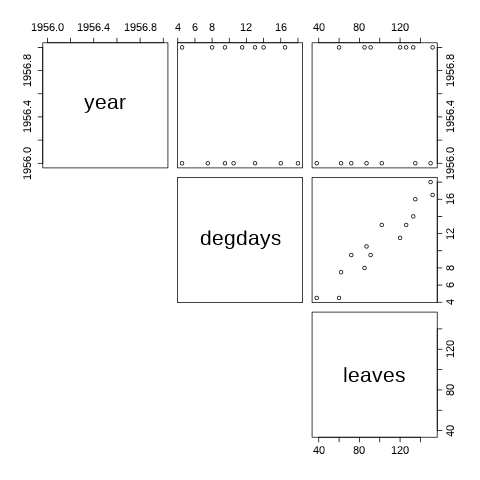

In [60]:
%%R
pairs(count.data, lower.panel = NULL)

The `pairs()` function creates a scatterplot matrix of the variables in the dataset. The plot shows the relationships between the variables, including the count of leaves, the number of plants, and the time of observation. The scatterplot matrix helps visualize the relationships between the variables and identify any patterns or trends in the data.


In [61]:
%%R
# Fit a Poisson regression model using the glm() function
pois.glm = glm(leaves ~ year + degdays, data=count.data, family=c("poisson"))
# Fit a Poisson regression model using the gam() function
pois.gam = gam(leaves ~ year + s(degdays), data=count.data, family=c("poisson"))

In [62]:
%%R
anova(pois.glm, pois.gam)

Analysis of Deviance Table

Model 1: leaves ~ year + degdays
Model 2: leaves ~ year + s(degdays)
  Resid. Df Resid. Dev      Df Deviance Pr(>Chi)
1    11.000     6.0593                          
2    10.569     4.8970 0.43106   1.1623   0.1131


The `anova()` function compares the two models using the likelihood ratio test. The output shows the difference in deviance between the two models, the degrees of freedom, and the p-value for the test. In this case, the p-value is more than 0.05, indicating that the glm model is a better fit than the gam model.

#### GAM model for Overdispersion in Count Data

For overdispersed data we have the option to use both the quasipoisson and the negative binomial distributions:

In [63]:
%%R
# Fit a Quasipoisson regression model using the gam() function
pois.gam.quasi = gam(leaves ~ year + s(degdays), data=count.data, family=c("quasipoisson"))
summary(pois.gam.quasi)


Family: quasipoisson 
Link function: log 

Formula:
leaves ~ year + s(degdays)

Parametric coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -400.60775   69.08499  -5.799 0.000168 ***
year           0.20708    0.03531   5.865 0.000153 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
             edf Ref.df     F p-value    
s(degdays) 1.916   2.39 151.7  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =   0.97   Deviance explained = 97.6%
GCV = 0.58311  Scale est. = 0.4138    n = 14


In [64]:
%%R
# Fit a Negative Binomial regression model using the gam() function
pois.gam.nb = gam(leaves ~ year + s(degdays), data=count.data, family=nb())
summary(pois.gam.nb)


Family: Negative Binomial(12809990.186) 
Link function: log 

Formula:
leaves ~ year + s(degdays)

Parametric coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -407.46534  106.35067  -3.831 0.000127 ***
year           0.21059    0.05436   3.874 0.000107 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
             edf Ref.df Chi.sq p-value    
s(degdays) 1.509  1.856  155.8  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.967   Deviance explained = 97.3%
-REML = 54.995  Scale est. = 1         n = 14


## Summary and Conclusions

In this tutorial, we covered the basics of Generalized Additive Models (GAMs) in R, focusing on their ability to model complex, nonlinear relationships in data. We started with an overview of how GAMs extend traditional linear models by incorporating flexible, smooth effects for each predictor, making them suitable for nonlinear data. We then explored various R packages, including `mgcv` and `gam`, which provide user-friendly functions for fitting and evaluating GAMs, visualizing fitted effects, and assessing model diagnostics. To further understand GAM mechanics, we built a GAM from scratch without using external packages. This hands-on experience demonstrated key principles such as using basis functions for smoothing and the model's additive nature, allowing us to isolate and effectively combine predictors' effects. We fit GAM with count and binary data, showcasing their versatility in handling different types of data.

### Resources

1.  [Generalized Additive Models-An introduction with R](https://www.taylorfrancis.com/books/mono/10.1201/9781315370279/generalized-additive-models-simon-wood)

2.  [Generalized Additive Models Using R](https://www.geeksforgeeks.org/generalized-additive-models-using-r/)

3.  [Chapter 4 Introduction to GAMs](https://r.qcbs.ca/workshop08/book-en/introduction-to-gams.html)

4.  [Generalized Additive Models](https://www.r-bloggers.com/2017/07/generalized-additive-models/)

5.  [GAM: The Predictive Modeling Silver Bullet](https://multithreaded.stitchfix.com/blog/2015/07/30/gam/)

6.  [Generalized Additive Models](https://m-clark.github.io/generalized-additive-models/)

7. [Generalized Additive Models and Mixed-Effects in Agriculture](https://r-video-tutorial.blogspot.com/2017/07/generalized-addictive-models-and-mixed.html)